$\newcommand{\xv}{\mathbf{x}}
 \newcommand{\wv}{\mathbf{w}}
 \newcommand{\yv}{\mathbf{y}}
 \newcommand{\zv}{\mathbf{z}}
 \newcommand{\Chi}{\mathcal{X}}
 \newcommand{\R}{\rm I\!R}
 \newcommand{\sign}{\text{sign}}
 \newcommand{\Tm}{\mathbf{T}}
 \newcommand{\Xm}{\mathbf{X}}
 \newcommand{\Zm}{\mathbf{Z}}
 \newcommand{\Wm}{\mathbf{W}}
 \newcommand{\Ym}{\mathbf{Y}}
 \newcommand{\I}{\mathbf{I}}
 \newcommand{\muv}{\boldsymbol\mu}
 \newcommand{\Sigmav}{\boldsymbol\Sigma}
$

# Autoencoders

Auto-encoders are the framework for learning features with neural network bottelneck structure. The model redudes the number of features in an unsupervised way. 
Encoding and decoding or dimensionality reduction can be done in variouus ways.
Autoencoders, however, utilize the neural network structure by simply copying the input to their outputs for the codings. Then, it learns to shrink input dimensions into lower dimensional embeddings in the bottleneck layer. 

![](http://webpages.uncc.edu/mlee173/teach/itcs4156online/images/class/linear_AE.png)


We can write the linear encoder and decoder as: 
$$
  \zv = f_{enc}(\xv) = \wv_{enc} \xv + b_{enc}, \\
  \xv^\prime = f_{dec}(\zv) = \wv_{dec} \zv + b_{dec} \\
$$
where $\zv$ is the encoded vector. 
When the cardinality (length) of $\zv$ is less than the one of $\xv$, $\vert \zv \vert \lt \vert \xv \vert$, we call the autoencoder *undercomplete*. Ohterwise, $\vert \zv \vert \gt \vert \xv \vert$, it is called *overcomplete* autoencoders. Undercomplete autoencoders have a bottlenect structure to reduce the dimensionality of encoded vector. 

The loss function can be defined as:
$$
  L\Big(\xv, f_{dec}\big( f_{enc}(\xv) \big) \Big) = \Vert \xv - \xv^\prime \Vert^2. 
$$

In [25]:
# preparation 

import tensorflow as tf
from tensorflow import keras 
# Common imports
import numpy as np
import os
import sys
os.environ['KMP_DUPLICATE_LIB_OK']='True'   #TF2: to fix Jupyter down
tf.keras.backend.set_floatx('float64')

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import IPython.display as ipd  # for display and clear_output

from IPython.display import clear_output, Image, display, HTML

# Linear Autoencoder

With the linear activation function and the cost function is the mean squared error (MSE), we can build a linear autoencoder as follows. First of all, let us prepare toy data. 

In [26]:
# Prepare data

import numpy.random as rnd

rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

# normalize it
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])


The linear autoencoder with 3 inputs and 2 hidden units in the bottleneck can be written as below. 

In [27]:
n_inputs = 3
n_hidden = 2  # codings
n_outputs = n_inputs

learning_rate = 0.01


inp = keras.layers.Input(shape=[n_inputs])
enc = keras.layers.Dense(n_hidden)(inp)
out = keras.layers.Dense(n_outputs)(enc)

encoder = keras.Model(inp, enc)
model = keras.Model(inp, out)


# compile the model
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_31 (Dense)             (None, 2)                 8         
_________________________________________________________________
dense_32 (Dense)             (None, 3)                 9         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


The model can be easily trained as we practiced with general deep neural network last time. 

In [28]:
history = model.fit(X_train, X_train, epochs=10)

Train on 100 samples
Epoch 1/10
100/100 [==============================] - 1s 10ms/sample - loss: 1.5633 - MSE: 1.5633 - MAE: 0.9077
Epoch 2/10
100/100 [==============================] - 0s 228us/sample - loss: 1.5344 - MSE: 1.5344 - MAE: 0.8985
Epoch 3/10
100/100 [==============================] - 0s 165us/sample - loss: 1.5064 - MSE: 1.5064 - MAE: 0.8894
Epoch 4/10
100/100 [==============================] - 0s 137us/sample - loss: 1.4776 - MSE: 1.4776 - MAE: 0.8799
Epoch 5/10
100/100 [==============================] - 0s 172us/sample - loss: 1.4510 - MSE: 1.4510 - MAE: 0.8712
Epoch 6/10
100/100 [==============================] - 0s 277us/sample - loss: 1.4252 - MSE: 1.4252 - MAE: 0.8626
Epoch 7/10
100/100 [==============================] - 0s 260us/sample - loss: 1.3989 - MSE: 1.3989 - MAE: 0.8541
Epoch 8/10
100/100 [==============================] - 0s 269us/sample - loss: 1.3728 - MSE: 1.3728 - MAE: 0.8457
Epoch 9/10
100/100 [==============================] - 0s 510us/sample - loss

Now, we are ready to check how the encoding looks like. We plot the original 3-dimensional data in 3D and then plot the embeddings in 2D next. What do you see from it? 

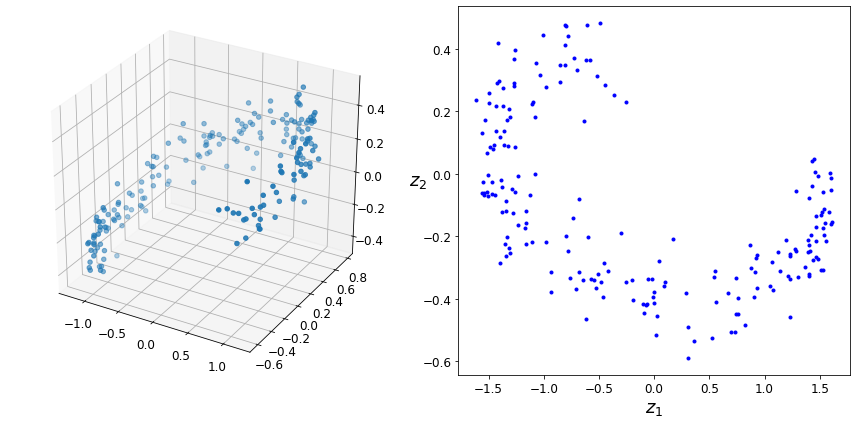

In [29]:
from mpl_toolkits.mplot3d import Axes3D

codings_val = encoder(data)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(data[:,0], data[:, 1], data[:, 2])

fig.add_subplot(122)
plt.plot(codings_val[:,0], codings_val[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)

plt.tight_layout()

# MNIST Data for Pactice

MNIST handwritten digit data set is well-known benchmark test for classification of images. As shown below, it contains 60,000 digit images in training data set. In this practice, we try to encode the images into lower dimensional embeddings and the decode the encodings to see how well it reconstructs the orginal input images. 

In [174]:
# loading data
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [33]:
x_train.shape

(60000, 28, 28)

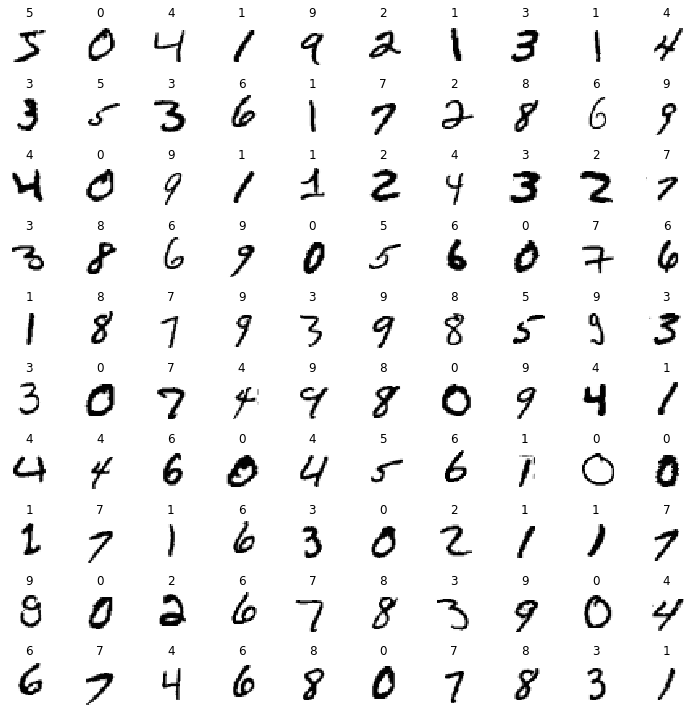

In [34]:
plt.figure(figsize=(10, 10))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(-x_train[i], interpolation='nearest', cmap='gray')
    plt.axis('off')
    plt.title(y_train[i])
plt.tight_layout()

In [175]:
x_train[0].size

784

In [178]:
x_train = x_train.reshape((x_train.shape[0], x_train[0].size))
x_test = x_test.reshape((x_test.shape[0], x_test[0].size))

# Stacked Autoencoder 

To handle complex data encodings, we can simply apply nonlinear activation. Also, we can make it *deep* as we practice deep learning for more complex codings. As our text warned, however, we need to be careful when building too deep so that we loose generalization of our stacked autoencoder. 

Following figure shows the sysmetrically built autoencoder for MNIST data set. 

![](http://webpages.uncc.edu/mlee173/teach/itcs4156online/images/class/SAE.png)


In [179]:
#n_inputs = x_train[0].size
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

model = keras.Sequential([
            keras.layers.Input(shape=(n_inputs,)),
            keras.layers.Dense(n_hidden1, activation='elu', kernel_initializer='he_normal'),
            keras.layers.Dense(n_hidden2, activation='elu', kernel_initializer='he_normal'),
            keras.layers.Dense(n_hidden3, activation='elu', kernel_initializer='he_normal'),
            keras.layers.Dense(n_outputs, kernel_initializer='he_normal')
        ])

model.compile(optimizer='adam', loss='mse')

model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_7 (Dense)              (None, 150)               45150     
_________________________________________________________________
dense_8 (Dense)              (None, 300)               45300     
_________________________________________________________________
dense_9 (Dense)              (None, 784)               235984    
Total params: 561,934
Trainable params: 561,934
Non-trainable params: 0
_________________________________________________________________


Here we extract the encoder from the previously built autoencoder.  

In [180]:
inp = keras.layers.Input(shape=(n_inputs,))
encoder = keras.Model(inp, model.layers[1](model.layers[0](inp)))
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_6 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_7 (Dense)              (None, 150)               45150     
Total params: 280,650
Trainable params: 280,650
Non-trainable params: 0
_________________________________________________________________


In [105]:
# Training the network! 

model.fit(x_train, x_train, epochs=5)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 68s 1ms/sample - loss: 0.0213
Epoch 2/5
60000/60000 [==============================] - 74s 1ms/sample - loss: 0.0067
Epoch 3/5
60000/60000 [==============================] - 54s 897us/sample - loss: 0.0051
Epoch 4/5
60000/60000 [==============================] - 53s 890us/sample - loss: 0.0047
Epoch 5/5
60000/60000 [==============================] - 52s 860us/sample - loss: 0.0045


During training, we stored the autoencoder. By using the encoder, the upper half of the network, we can encode and display for comparison.   

In [106]:
def show_reconstructed_digits(model, X, n_test_digits = 2, shape=(28, 28)):
    outputs_val = model(X)  # or model.predict(X)

    fig = plt.figure(figsize=(15, 6))
    sq = np.sqrt(n_test_digits)
    for digit_index in range(n_test_digits):
        plt.subplot(sq, 2*sq, digit_index * 2 + 1)
        plt.imshow(X[digit_index].reshape(shape), cmap="Greys", interpolation="nearest")
        plt.axis("off")
        plt.subplot(sq, 2*sq, digit_index * 2 + 2)
        plt.imshow(tf.reshape(outputs_val[digit_index], shape), cmap="Greys", interpolation="nearest")
        plt.axis("off")

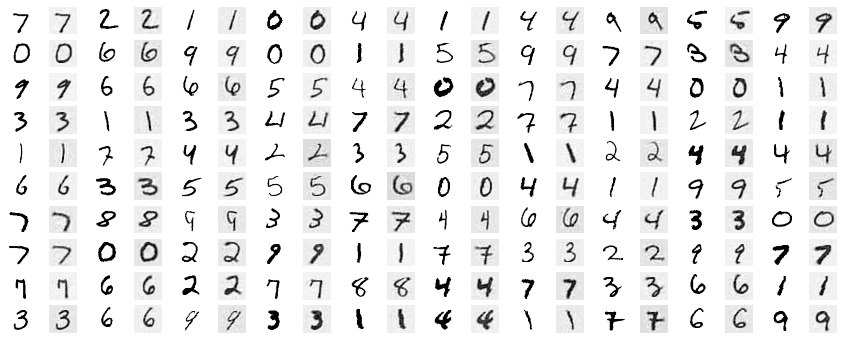

In [107]:
show_reconstructed_digits(model, x_test, 100)

What do you think? Does it recover well the original images? It seems to lose a little information with some noisy background, but the core digits for recognition is not lost. 

We can now take a look at how the lower dimensional representation contains any interesting characteristics. For this, we take only the first two dimensions of the 150 dimensional embeddings. When we plot the all the numbers in the test set, it looks as blew. 

In [160]:
def plot_codings2d(encodings, ys, filter=None, n_digits=500):

    plt.figure(figsize=(10,10))
    plt.xlim([encodings[:, 0].min(),encodings[:, 0].max()])
    plt.ylim([encodings[:, 1].min(),encodings[:, 1].max()])
    for i, txt in enumerate(ys[:n_digits]):
        if filter is None or txt in filter:
            plt.annotate(txt, (encodings[i, 0], encodings[i, 1]), color=''.join(['C', str(txt)]))

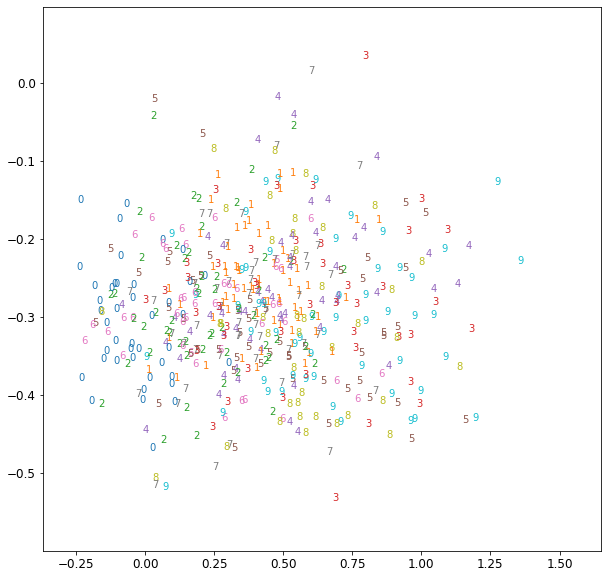

In [161]:
test_encoded = encoder(x_test)

plot_codings2d(test_encoded.numpy(), y_test)

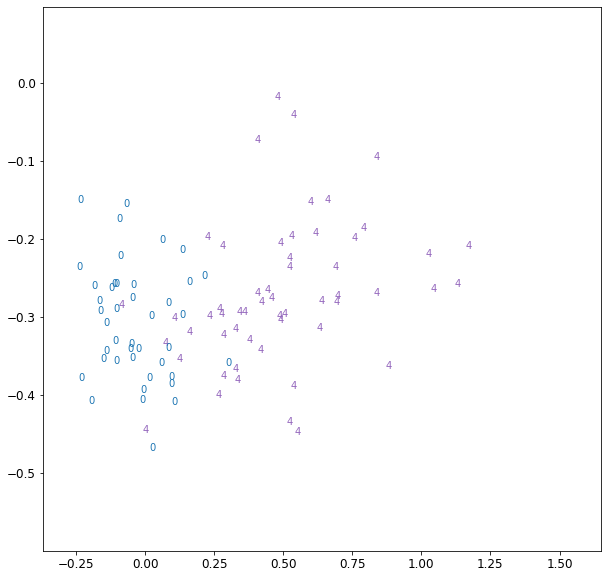

In [162]:
plot_codings2d(test_encoded.numpy(), y_test, [0, 4])

Do you obseve any gathering of the numbers in the embedding space? 

# Tying Weights

For the stacked autoencoder, we used two $28 \times 28$ input and output units, two 300 hidden units and 150 bottleneck units. In total, we are using 2,318 units for computation. For the symmetric networks, we can use the same weights for symmetric weights. Yes, we can *tie the weights* with simple transpose operation. 

When the first unit weight matrix is $\Wm_1$, then the output unit weights is simply $\Wm_1^\top$, and so on.  

In [165]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)
    
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [184]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

n_inputs = x_train[0].size
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs


dense_1 = keras.layers.Dense(n_hidden1, activation='elu', kernel_initializer='he_normal')
dense_2 = keras.layers.Dense(n_hidden2, activation='elu', kernel_initializer='he_normal')

tied_encoder = keras.Sequential([
            keras.layers.Input(shape=(n_inputs,)),
            dense_1,
            dense_2
        ])

tied_decoder = keras.Sequential([
            DenseTranspose(dense_2, activation="elu"),
            DenseTranspose(dense_1, activation="elu"),
        ])

tied_model = keras.models.Sequential([tied_encoder, tied_decoder])

tied_model.compile(optimizer='adam', loss='mse')

tied_model.fit(x_train, x_train, epochs=5)
tied_model.summary()

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 65s 1ms/sample - loss: 0.0103
Epoch 2/5
60000/60000 [==============================] - 50s 825us/sample - loss: 0.0044
Epoch 3/5
60000/60000 [==============================] - 47s 789us/sample - loss: 0.0041
Epoch 4/5
60000/60000 [==============================] - 48s 807us/sample - loss: 0.0041
Epoch 5/5
60000/60000 [==============================] - 45s 748us/sample - loss: 0.0041
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 150)               280650    
_________________________________________________________________
sequential_1 (Sequential)    multiple                  281734    
Total params: 281,734
Trainable params: 281,734
Non-trainable params: 0
_________________________________________________________________


Let us check if the reconstructed images are OK. 

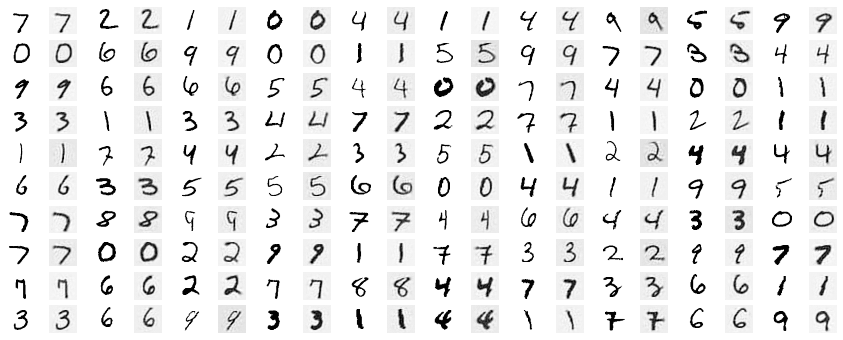

In [185]:
show_reconstructed_digits(tied_model, x_test, 100)

# Learning Faster by Decomposing Deep Networks

When the stacked autoencoders or deep networks have many layers, it is often useful or fast to train if you train a shallow layer at a time. The figure in our text depicts this process. 

![](http://webpages.uncc.edu/mlee173/teach/itcs4156online/images/class/train_AE.png)


In [186]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer,
                      n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.models.Sequential([
        keras.layers.Dense(n_neurons, activation="selu", input_shape=[n_inputs])
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(n_inputs, activation=output_activation),
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics=metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs,
                    validation_data=[X_valid, X_valid])
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [188]:
print("First, trainig the phase 1, outer shells...")
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100, x_train, x_train, "mse",
    keras.optimizers.SGD(lr=1.5))

print("\nNow, training inner layxers, phase 2....")
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, "mse", keras.optimizers.SGD(lr=0.05),
    output_activation="selu")

Train on 60000 samples, validate on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 30s 503us/sample - loss: 0.0311 - val_loss: 0.0182
Epoch 2/10
60000/60000 [==============================] - 23s 383us/sample - loss: 0.0150 - val_loss: 0.0128
Epoch 3/10
60000/60000 [==============================] - 25s 420us/sample - loss: 0.0116 - val_loss: 0.0106
Epoch 4/10
60000/60000 [==============================] - 24s 393us/sample - loss: 0.0100 - val_loss: 0.0094
Epoch 5/10
60000/60000 [==============================] - 21s 342us/sample - loss: 0.0089 - val_loss: 0.0085
Epoch 6/10
60000/60000 [==============================] - 24s 400us/sample - loss: 0.0082 - val_loss: 0.0080
Epoch 7/10
60000/60000 [==============================] - 24s 399us/sample - loss: 0.0077 - val_loss: 0.0075
Epoch 8/10
60000/60000 [==============================] - 20s 340us/sample - loss: 0.0074 - val_loss: 0.0072
Epoch 9/10
60000/60000 [==============================] - 18s 305us/sample - l

We have trained weights and biases in variables now. Using them to construct the stacked autoencoder. 

In [189]:
stacked_ae_1_by_1 = keras.models.Sequential([
    keras.layers.Input(shape=(n_inputs)),
    enc1, enc2, dec2, dec1,
    keras.layers.Reshape([28, 28])
])

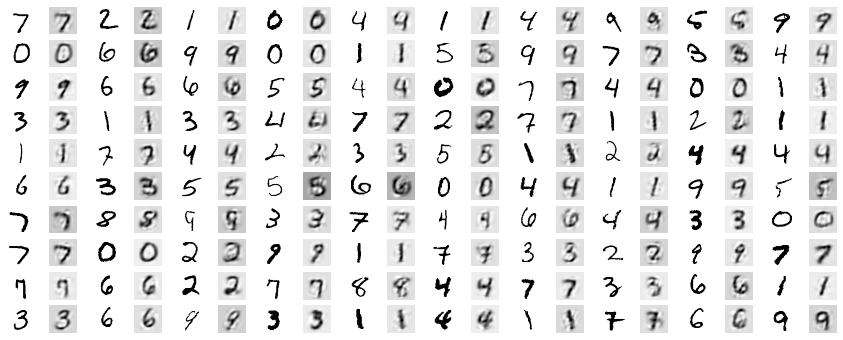

In [190]:
show_reconstructed_digits(stacked_ae_1_by_1, x_test, 100)

# What is it capturing from input? 

By looking at the weights, we can observe the activations of a certain part of images that represents a certain label. 


In [199]:
enc1.get_weights()[0].shape

(784, 100)

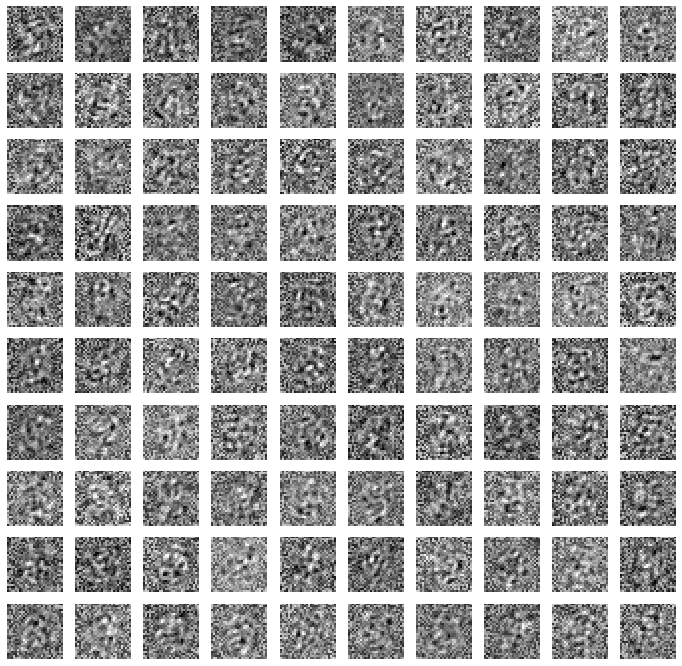

In [204]:
plt.figure(figsize=(12, 12))

W1 = enc1.get_weights()[0]
for i in range(100):
    plt.subplot(10, 10, i + 1)
    plt.imshow(W1[:, i].reshape((28, 28)), cmap="gray")
    plt.axis('off')

# Building a Classifier with Encoder

Now, we can reuse the upper part of the autoencoder, the encoder, to another deep networks for nonlinear classification or logistic regression. 
For this, we do not need to relearn from scratch. 

![](http://webpages.uncc.edu/mlee173/teach/itcs4156online/images/class/AE_classify.png)
